In [2]:
from functions.plots import circuit_plot,matrix_plot,stats_plot
from functions.calculating import get_cmap,get_matrix,get_stats, energy_cmap
from functions.importing import retrieve_chain,retrieve_cif
import os

In [3]:

fileformat = input('cif or pdb? (cif/pdb) \n')
if fileformat == 'cif':
    dlinput = input('Do you want to fetch CIF\'s from Database? pdblist.txt (y/n) \n')
    if dlinput:  
        efiltering  = input('apply energy filtering? (y/n)\n')
else:
    efiltering  = input('apply energy filtering? (y/n)\n')
    dlinput = 'n'

#Enter a list with protein names that need to be downloaded (pdblist.txt)
if dlinput == 'y':  
    retrieve_cif.retrieve_cif()

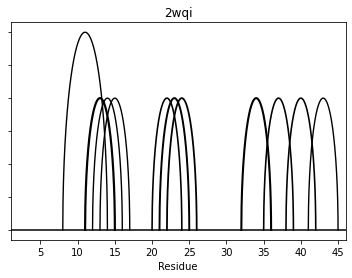

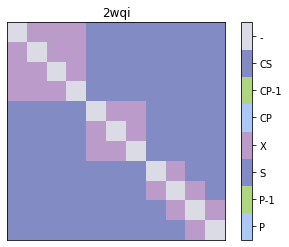

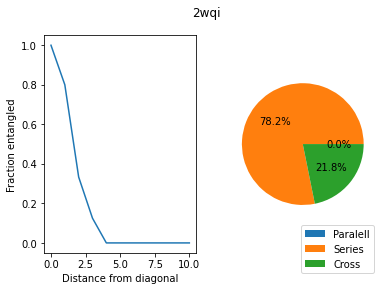

In [5]:
for files in os.listdir('input_files/' +fileformat):
    
    chain = retrieve_chain.retrieve_chain(files)
    
    #Step 1 - Draw a segment-segment based contact map (if length_filtering > 0, it is activated, input is the max distance)
    cmap3, cmap2, protid ,numbering, res_names = get_cmap.get_cmap(chain,length_filtering=0,cutoff_distance=3.6,cutoff_numcontacts=3)

    #Step 1.5 - Energy filteringcif
    if efiltering == 'y':
        cmap3,x = energy_cmap.energy_cmap(cmap3,numbering,res_names)
        protid = protid + '_ef'
        

    #Step 2 - Draw a circuit topology relations matrix
    mat, c = get_matrix.get_matrix(cmap3,protid)

    #Step 3 - Circuit topology statistics
    psc, entangled = get_stats.get_stats(mat,protid)

    #Plots
    
    circuit_plot.circuit_plot(cmap2,protid,numbering)
    matrix_plot.matrix_plot(mat,protid)
    stats_plot.stats_plot(entangled,psc,protid)